## Méthodes d'optimisation stochastique

## I. Minimisation stochastique d'une fonction déterministe


On s'intéresse au problème $\min f(x) =\max_{i=1\dots m}|a_i^Tx-b_i | = \max_{i=1\dots m} |(Ax-b)_i|.$ 

On suppose que $a_i$ est un vecteur colonne représentant la $i$eme ligne d'une matrice $A$ de taille $m \times n$ ($m=100, n=20$) , et les $b_i$ sont les composantes d'un second membre $b$ de taille $m$, ($1 \le i \le m$), $x$ un vecteur de taille $n$. Ces quantités sont générées une fois pour toutes à partir de distributions Gaussiennes de moyenne nulle et d'écart type identité.

**Question 1 :** Constuire $A$ et $b$. Proposer le calcul d'un sous-gradient en $x$ de $f$. On pourra utiliser la fonction findmax de Julia. 


In [30]:
#import Pkg
using Pkg
Pkg.add("JuMP")
Pkg.add("GLPK")
Pkg.add("Plots")
using JuMP
using GLPK
using Plots
using Distributions
using LinearAlgebra

    Updating registry at `~/.julia/registries/General`


    Updating git-repo `https://github.com/JuliaRegistries/General.git`


   Resolving package versions...


  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


   Resolving package versions...


  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


   Resolving package versions...


  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


ArgumentError: ArgumentError: Package Distributions not found in current path.
- Run `import Pkg; Pkg.add("Distributions")` to install the Distributions package.

In [2]:
?findmax


ErrorException: syntax: invalid identifier name "?"

In [1]:
# Construction des données A  et b

n = 20;
m = 100;
A = randn(m,n)               #pour créer une matrice de taille m par n remplie de nombres aléatoires
b = randn(m,1)
x = zeros(n,1)


# Fonction calculant un sous-gradient en x de f
function subgrad(A,b,x) 
    expr = abs.(A*x - b)
    (f,ind) = findmax(expr)  # La valeur maximale et l'indice correspondant dans f
    i = ind[1]               # On récupère l'indice du maximum
    return sign(expr[i]) .* (A[i,:])
end


subgrad (generic function with 1 method)

In [2]:
# f
function fval(A,b,x)
    return maximum(abs.(A*x - b))
end

fval (generic function with 1 method)

In [3]:
a = subgrad(A,b,x)
print(a)

[0.6267659900286182, 0.4559529536677851, -2.0279034450677225, -0.7064009847520976, -0.28372897546986764, -0.9829437211550255, -1.73149890413357, 0.22136915488274678, 1.414564290521088, 0.19413205555323723, 0.06017746072587087, -1.5672469201607093, -0.3215062775937298, -0.015629450954955576, 0.9908566545825913, 0.4084556303573901, 0.6432795398209146, -0.07940297738484853, -0.9405721093536075, 0.07099921268819462]

**Question 2 :** Ce problème peut se reformuler comme un problème de programmation linéaire : $$(\mathcal{P}_{lp})\quad \left\{ \begin{array}{c} \min_{(x,R)\in \mathbb{R}^n\times \mathbb{R}} h(x,R)=R\\
s.c. \quad-R*e\leq A*x-b\leq R*e\end{array}\right.$$ avec $e=[1,\cdots,1]^T\in \mathbb{R}^m$. Résoudre le problème $(\mathcal{P}_{lp})$ en utilisant le solveur "GLPK" de la librairie JuMP. Plus d'informations sont disponibles ici :  http://www.juliaopt.org/JuMP.jl/latest/quickstart/

In [4]:
#using Pkg
#Pkg.add("JuMP"); 
#Pkg.add("GLPK")
using JuMP
using GLPK

# Définition du modèle
modele = Model(GLPK.Optimizer);

# Définition des variables d'optimisation
@variable(modele, x[1:n]);
@variable(modele, R)

# Définition de la fonctionnelle à minimiser
@objective(modele, Min, R);

# Définition des contraintes
for i = 1:m
@constraint(modele,  sum(A[i,j]*x[j] for j in 1:n) - b[i] >= -R);
@constraint(modele,  sum(A[i,j]*x[j] for j in 1:n) - b[i] <= R);
end
# Résolution        
optimize!(modele);
        
# Résultats à optimalité                
#println(solution_summary(model))
# solution_summary dans l'objet GLPK.Solution renvoie un résumé détaillé de la solution optimale 
#obtenue par le solveur GLPK pour un problème d'optimisation linéaire en Julia.

xstar = value.(x)
Rstar = value(R)
println("The function value at the solution is: ",Rstar, " or ",findmax(abs.(A*xstar-b)))

     

The function value at the solution is: 1.704680647541364 or (

1.7046806475413665, CartesianIndex(32, 1))


**Question 3 :** Résoudre le problème en utilisant un algorithme de sous-gradient. Dans un premier temps vous utiliserez un sous-gradient exact (Question 1), puis vous introduirez un bruit artificiel qui suit une distribution normale de moyenne nulle et d'écart-type $3 e-1$.

**Question 4 :** Vous afficherez les courbes de convergence de $f_{best}^k-f_{star}$, avec $f_{star}$ obtenue à la Question 1. Donnez la valeur minimale de $f_{best}^k-f_{star}$.

la valeur min de fbest-fstar est : 0.6918249394171523
la valeur min de fbestp-fstar est : 0.7018639875752568


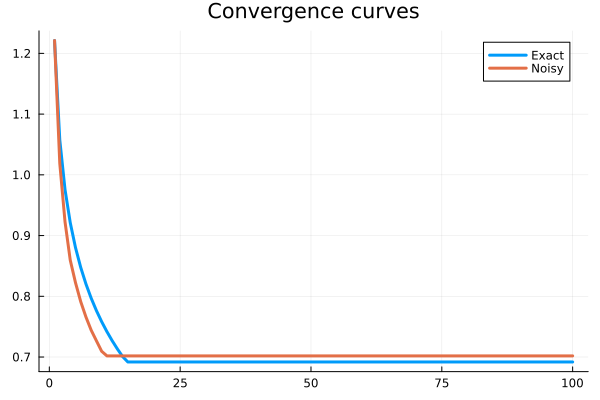

In [5]:
#Pkg.add("Plots")
using Plots

#Initialisation
x = zeros(n,1);
i = 0;
fbest =1e10; # $f_{best}^0$: cas du sous-gradient exact
fbestp=1e10; # $f_{best}^0$: cas du sous-gradient bruité
histo =[];# Suite des itérés f_{best}^k-f_{star} pour le cas du sous-gradient exact
histop=[];# Suite des itérés f_{best}^k-f_{star}, pour le cas du sous-gradient bruité

#Niveau de bruit
noise_lvl=.3;

# Resolution 
# On initialise les variables
itermax = 100;
xk = x;
xk_perturbe = x;
fstar = Rstar;

liste_min = zeros(itermax);
liste_min_perturbe = zeros(itermax);

for i in 1:itermax
    alpha = 1/(itermax*i);
    current_sol_value = fval(A,b,xk);
    if current_sol_value < fbest
        fbest = current_sol_value;
    end
    current_gradient = subgrad(A, b, xk);
    xk = xk - alpha*current_gradient;

    liste_min[i] = fbest-fstar;
    append!(histo, fbest-fstar)

    #Ajout du bruit
    current_sol_value_perturbe = fval(A,b,xk_perturbe);
    if current_sol_value_perturbe < fbestp
        fbestp = current_sol_value_perturbe;
    end
    #ajout du bruit au sous gradient
    current_gradient_perturbe = subgrad(A, b, xk_perturbe) + randn(n,1)*noise_lvl;
    xk_perturbe = xk_perturbe - alpha*current_gradient_perturbe;
    
    liste_min_perturbe[i] = fbestp-fstar;
    append!(histop, fbestp-fstar)
end
println("la valeur min de fbest-fstar est : ", minimum(liste_min))
println("la valeur min de fbestp-fstar est : ", minimum(liste_min_perturbe))

#Affichage des courbes de convergence
iter=1:itermax;
hf=[histo,histop];
plot(iter,hf,title="Convergence curves",label=["Exact" "Noisy"],lw=3)

## II. Minimisation stochastique d'une fonction stochatique



On s'intéresse au problème
$$\min_x f(x) =\text{E} (\max_{i=1\dots m}|a_i^Tx-b_i |).$$

On suppose que $a_i$ est un vecteur colonne représentant la $i$eme ligne d'une matrice $A$ de taille $m \times n$ ($m=100, n=20$) , et les $b_i$ sont les composantes d'un second membre $b$ de taille $m$, ($1 \le i \le m$), $x$ un vecteur de taille $n$. Ces quantités sont générées une fois pour toutes à partir de distributions Gaussiennes de moyenne connue $\bar{A}$ et $\bar{b}$ (non nécesairement nulle) et d'écart type identité.

**Question 5 :** Proposer deux fonctions d'évaluation de la fonction $f$ et d'un sous-gradient de $f$ basées sur des échantillons de taille $M$.


In [6]:
# Evaluation de f
function fvals(Abar,bbar,noise,xs,M) 
    # Abar, bbar : moyenne des données
    # noise : niveau de bruit 
    # xs : vecteur courant 
    # M: taille de l'échantillon
    somme =0;
    for i in 1:M
        # Données bruitées
        Abar += noise * randn(size(A))
        bbar += noise * randn(size(b))
        
        # Calcul de la valeur de la fonction objectif
        fval_i = fval(Abar, bbar, xs)
        
        # Ajout à la somme
        somme += fval_i
    end
    
    # Moyenne des valeurs de la fonction objectif
    res = somme / M
    return res
    
end

# Evaluation d'un sous-gradient
function subgrads(Abar,bbar,noise,xs,M)
    # Abar, bbar : moyenne des données
    # noise : niveau de bruit 
    # xs : vecteur courant 
    # M: taille de l'échantillon
    somme = zeros(n,1);

    for i in 1:M
        # Données bruitées
        Abar += noise * randn(size(A))
        bbar += noise * randn(size(b))
        
        # Calcul du sous-gradient
        subgrad_i = subgrad(Abar, bbar, xs)
        
        # Ajout à la somme
        somme += subgrad_i  
    end
    res = somme / M
    return res

end


subgrads (generic function with 1 method)

**Question 6 :** Comparer les courbes de convergence du problème déterministe $$ \min_x f(x) = \max_{i=1\dots m}|\text{E} (a_i)^Tx-\text{E} (b_i) |,$$ et du problème stochastique obtenu avec $M=10,100,1000$ échantillons. Donnez la valeur minimale de $f$.

la valeur min de fbestd : 212.0795635652053
la valeur min de fbests : 416.9973730797626


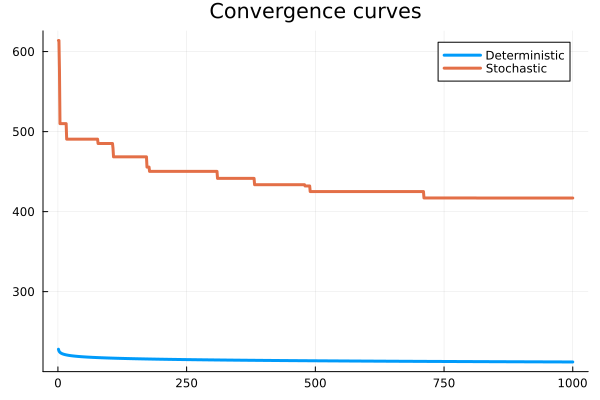

In [7]:
# Données
Abar=10*ones(m,n)+1*randn(m,n);
bbar=10*randn(m,1);

#x_0
xd = ones(n,1); # problème déterministe
xs = xd; # problème stochastique
# Bruit et echantillon
M  = 200;
noise  = 4;

j = 0;

fbestd =1e10; # $f_{best}^0$: cas d'une résolution déterministe
fbests =1e10; # $f_{best}^0$: cas d'une résolution stochastique
histod =[]; # Suite des itérés f_{best}^k pour le cas d'une résolution déterministe
histos =[]; # Suite des itérés f_{best}^k pour le cas d'une résolution stochastique


itermax = 1000;
x_det = xd;
x_stoch = xs;
liste_min_d = zeros(itermax)
liste_min_s = zeros(itermax)


for i in 1:itermax
    alpha = 1/(itermax*i);
    
    #calcul avec le gradient déterministe
    f_eval_det = fval(Abar,bbar,x_det);
    if f_eval_det < fbestd
        fbestd = f_eval_det;
    end
    g_det = subgrad(Abar,bbar,x_det);
    x_det = x_det - alpha*g_det;
    liste_min_d[i] = fbestd;
    append!(histod, fbestd)

    #calcul avec le gradient stochastique
    f_eval_stoch = fvals(Abar,bbar,noise,x_stoch,M);
    if f_eval_stoch < fbests 
        fbests = f_eval_stoch;
    end
    g_stoch = subgrads(Abar,bbar,noise,x_stoch,M);
    x_stoch = x_stoch - alpha*g_stoch;
    liste_min_s[i] = fbests;
    append!(histos, fbests)
end


println("la valeur min de fbestd : ", minimum(liste_min_d))
println("la valeur min de fbests : ", minimum(liste_min_s))
#Affichage

iter=1:itermax;
hf=[histod,histos];
plot(iter,hf,title="Convergence curves",label=["Deterministic" "Stochastic"],lw=3)

**Question 7 :** Répéter les expériences et comparer les valeurs meilleurs valeurs de f obtenues ($f_{best}$) aprs un nombre fixé d'itérations. Donnez la valeur minimale de $f_{best}$

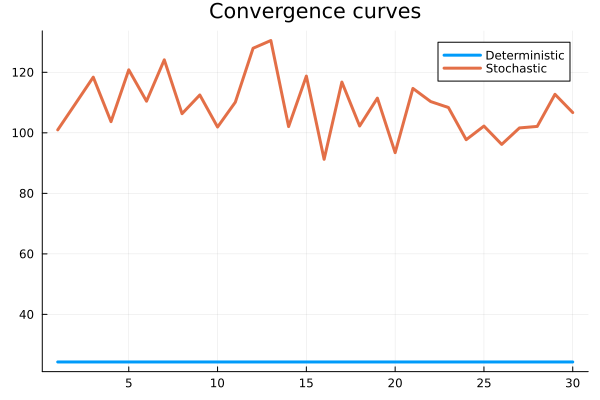

In [13]:
# Données
Abar=10*ones(m,n)+1*randn(m,n);
bbar=10*randn(m,1);

# x_0
xd = zeros(n,1); # résolution déterministe
xs = xd;  # résolution stochastique

# Bruit et echantillon
M  = 200;
noise  = 4;

#Nombre d'itérations
niter=100;

j = 0;

fbestd =1e10; # $f_{best}^0$: cas d'une résolution déterministe
fbests =1e10; # $f_{best}^0$: cas d'une résolution stochastique
fbesttd=[]; # f_{best} pour chaque expériences dans le cas d'une résolution déterministe
fbestts=[]; # f_{best} pour chaque expériences dans le cas d'une résolution stochastique
nfixe = 30
for nexp=1:nfixe
    fbestd =1e10; # résolution déterministe
    fbests =1e10; # résolution stochastique
    x_det = xd; 
    x_stoch = xs;
    for i in 1:niter
        alpha = 1/i;

        #calcul avec le gradient deterministe
        f_eval_det = fval(Abar,bbar,x_det);
        if f_eval_det < fbestd
            fbestd = f_eval_det;
        end
        g_det =subgrad(Abar,bbar,x_det);
        x_det = x_det - alpha*g_det;

        #calcul avec le gradient stochastique
        f_eval_stoch = fvals(Abar,bbar,noise,x_stoch,M);
        if f_eval_stoch < fbests
            fbests = f_eval_stoch;
        end
        g_stoch = subgrads(Abar,bbar,noise,x_stoch,M);
        x_stoch = x_stoch - alpha*g_stoch;
    end
    append!(fbesttd, fbestd)
    append!(fbestts, fbests)
end
#Affichage

iter=1:nfixe;
hf=[fbesttd,fbestts];
plot(iter,hf,title="Convergence curves",label=["Deterministic" "Stochastic"],lw=3)



In [12]:
println("la valeur min de fbestd : ", minimum(liste_min_d))
println("la valeur min de fbests : ", minimum(liste_min_s))


la valeur min de fbestd : 212.0795635652053
la valeur min de fbests : 416.9973730797626
